# Setup

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf


# Load dataset
https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent

In [2]:
root_path = "/Users/mai/Projects/GitHub/ML701-AilmentClassification/data/"
ailments_data = pd.read_csv(root_path + "ailments.csv", encoding="ISO-8859-1")

print(ailments_data.shape)

ailments_data = ailments_data.drop_duplicates()
print(ailments_data.shape)

print("Missing values: ", ailments_data.isnull().sum())

ailments_data.info()

ailments_data.head()


(6661, 2)
(707, 2)
Missing values:  phrase    0
prompt    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 3271
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  707 non-null    object
 1   prompt  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound


# Text Augmentation

In [3]:
# %pip install nlpaug
import nlpaug.augmenter.word as naw


def dataAugFun(ailments_data, N):
    """Increase the number of samples by data augmentation

    Args:
        ailments_data (DataFrame): contains the data
        N (int): number of samples to be generated

    Returns:
        DataFrame: data after augmentation
    """
    aug_data = ailments_data.head(0)

    texts = ailments_data["phrase"]
    for ind in ailments_data.index:
        texts = ailments_data["phrase"][ind]
        label = ailments_data["prompt"][ind]
        aug = naw.RandomWordAug(action="swap")
        augmented_text = aug.augment(texts, n=N)

        for string in augmented_text:
            aug_data = aug_data.append(
                {"phrase": string, "prompt": label}, ignore_index=True
            )

    return aug_data


/home/mai.kassem/.conda/envs/myenv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


In [4]:
ailments_data = dataAugFun(ailments_data, 4)
ailments_data.to_csv(root_path + "aug_ailments.csv", index=False)


# EDA

## Class distribution

<AxesSubplot:>

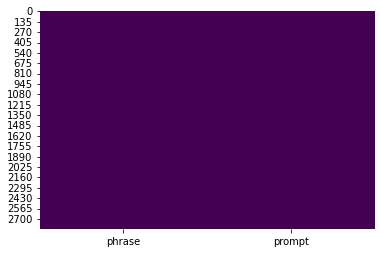

In [5]:
# visualizing the missing data
sns.heatmap(ailments_data.isnull(), cbar=False, cmap="viridis")


In [6]:
# number of ailments
print("Number of categories: ", ailments_data["prompt"].nunique())

# print class distribution
counter = Counter(ailments_data["prompt"])
for k, v in counter.items():
    per = v / len(ailments_data["prompt"]) * 100
    print("Class=%s, n=%d (%.3f%%)" % (k, v, per))


Number of categories:  25
Class=Emotional pain, n=96 (3.395%)
Class=Hair falling out, n=112 (3.960%)
Class=Heart hurts, n=124 (4.385%)
Class=Infected wound, n=136 (4.809%)
Class=Foot ache, n=108 (3.819%)
Class=Shoulder pain, n=140 (4.950%)
Class=Injury from sports, n=108 (3.819%)
Class=Skin issue, n=116 (4.102%)
Class=Stomach ache, n=108 (3.819%)
Class=Knee pain, n=128 (4.526%)
Class=Joint pain, n=136 (4.809%)
Class=Hard to breath, n=100 (3.536%)
Class=Head ache, n=108 (3.819%)
Class=Body feels weak, n=104 (3.678%)
Class=Feeling dizzy, n=104 (3.678%)
Class=Back pain, n=108 (3.819%)
Class=Open wound, n=88 (3.112%)
Class=Internal pain, n=104 (3.678%)
Class=Blurry vision, n=104 (3.678%)
Class=Acne, n=136 (4.809%)
Class=Muscle pain, n=116 (4.102%)
Class=Neck pain, n=100 (3.536%)
Class=Cough, n=124 (4.385%)
Class=Ear ache, n=112 (3.960%)
Class=Feeling cold, n=108 (3.819%)


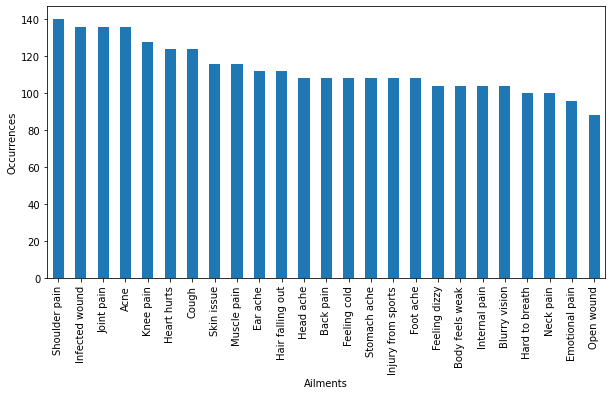

In [7]:
plt.figure(figsize=(10, 5))
ailments_data["prompt"].value_counts().plot(kind="bar")
plt.xlabel("Ailments")
plt.ylabel("Occurrences")
plt.show()


==> ***Dataset is balanced***

# Data Preprocessing

In [8]:
from sklearn import preprocessing
import numpy

# convert labels to numbers
le = preprocessing.LabelEncoder()
le.fit(ailments_data["prompt"])

le.classes_


y = le.transform(ailments_data["prompt"])
# print(le.inverse_transform(y))


# compare before and after
print(ailments_data["prompt"].value_counts())
unique, counts = numpy.unique(y, return_counts=True)
afterEncoder = dict(zip(unique, counts))
dict(sorted(afterEncoder.items(), key=lambda item: item[1], reverse=True))


Shoulder pain         140
Infected wound        136
Joint pain            136
Acne                  136
Knee pain             128
Heart hurts           124
Cough                 124
Skin issue            116
Muscle pain           116
Ear ache              112
Hair falling out      112
Head ache             108
Back pain             108
Feeling cold          108
Stomach ache          108
Injury from sports    108
Foot ache             108
Feeling dizzy         104
Body feels weak       104
Internal pain         104
Blurry vision         104
Hard to breath        100
Neck pain             100
Emotional pain         96
Open wound             88
Name: prompt, dtype: int64


{22: 140,
 0: 136,
 14: 136,
 17: 136,
 18: 128,
 4: 124,
 13: 124,
 19: 116,
 23: 116,
 5: 112,
 10: 112,
 1: 108,
 7: 108,
 9: 108,
 12: 108,
 15: 108,
 24: 108,
 2: 104,
 3: 104,
 8: 104,
 16: 104,
 11: 100,
 20: 100,
 6: 96,
 21: 88}

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
%pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def text_transform(message):
    """Tokenization and lemmatization of text

    Args:
        message (string): input text

    Returns:
        string: text after transformation
    """

    # (a) change the message to lowercase
    message = message.lower()

    # (b) tokenize the message,
    # i.e. if input = 'i am a student.'
    # then, output  = ['i', 'am', 'a', 'student', '.']
    message = word_tokenize(message)

    # (c) remove special characters in the message
    msg_temp = []
    for word in message:
        # only accpet the alpha-numeric words and remove all other cases e.g. special characters
        if word.isalnum():
            msg_temp.append(word)

    message = msg_temp

    # (d) remove stopwords and punctuations
    msg_temp = []
    for word in message:
        if word not in stopwords.words('english') and word not in string.punctuation:
            msg_temp.append(word)

    message = msg_temp

    # (e) lemmatization function
    lemmatizer = WordNetLemmatizer()
    msg_temp = []
    for word in message:
        msg_temp.append(lemmatizer.lemmatize(word))

    # join all words with space and return new message
    new_message = " ".join(msg_temp)

    return new_message


ailments_data
# apply the pre-processing steps via text_transform() function on text data
ailments_data['transformed_phrase'] = ailments_data['phrase'].apply(
    text_transform)

X = ailments_data.transformed_phrase
X.tail()


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/mai.kassem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2823               wound surgical infection
2824    redness swelling walking difficulty
2825    redness swelling walking difficulty
2826    swelling redness walking difficulty
2827    redness swelling difficulty walking
Name: transformed_phrase, dtype: object

Total number of unique words : 971


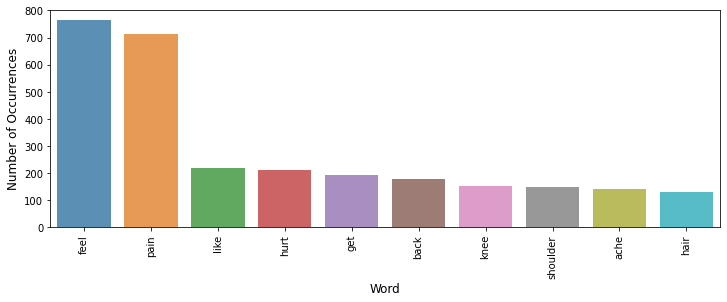

In [10]:
def counter_word(text_col):
    # count unique words
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(ailments_data["transformed_phrase"])


num_unique_words = len(counter)
print("Total number of unique words : " + str(num_unique_words))

# print(counter)

counted_df = (
    pd.DataFrame(counter.items(), columns=["word", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)  # create new df from counter

plt.figure(figsize=(12, 4))
# plot only the top 10 by slicing the df
sns.barplot(data=counted_df[:10], x="word", y="count", alpha=0.8)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xlabel("Word", fontsize=12)
plt.xticks(rotation=90)
plt.show()


In [11]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence


def get_max_input_length(docs):
    max_input_length = 1
    for document in docs:
        words = text_to_word_sequence(document)
        document_length = len(words)
        if document_length > max_input_length:
            max_input_length = document_length

    return max_input_length


# Training & Evaluating

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(X)

# each word has a unique index

word_index = tokenizer.word_index

word_index


{'feel': 1,
 'pain': 2,
 'like': 3,
 'hurt': 4,
 'get': 5,
 'back': 6,
 'knee': 7,
 'shoulder': 8,
 'ache': 9,
 'hair': 10,
 'cold': 11,
 'foot': 12,
 'head': 13,
 'ear': 14,
 'skin': 15,
 'lot': 16,
 'body': 17,
 'neck': 18,
 'stomach': 19,
 'time': 20,
 'wound': 21,
 'heart': 22,
 'muscle': 23,
 'joint': 24,
 'hard': 25,
 'sharp': 26,
 'walk': 27,
 'every': 28,
 'stand': 29,
 'breath': 30,
 'dizzy': 31,
 'cut': 32,
 'acne': 33,
 'cough': 34,
 'arm': 35,
 'left': 36,
 'face': 37,
 'feeling': 38,
 'go': 39,
 'infected': 40,
 'something': 41,
 'day': 42,
 'chest': 43,
 'great': 44,
 'inside': 45,
 'think': 46,
 'vision': 47,
 'heavy': 48,
 'much': 49,
 'weak': 50,
 'tried': 51,
 'red': 52,
 'move': 53,
 'even': 54,
 'see': 55,
 'sensation': 56,
 'morning': 57,
 'falling': 58,
 'football': 59,
 'playing': 60,
 'problem': 61,
 'try': 62,
 'since': 63,
 'blurry': 64,
 'pimple': 65,
 'eat': 66,
 'look': 67,
 'ankle': 68,
 'make': 69,
 'still': 70,
 'open': 71,
 'sore': 72,
 'right': 73,
 't

In [13]:
# max number of words in a sequence
max_length = get_max_input_length(X)
print("max_length: ", max_length)

train_sequences = tokenizer.texts_to_sequences(X)


max_length:  13


In [14]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(train_sequences, maxlen=max_length,
                  padding="post", truncating="post")


In [15]:
# LSTM model
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold


def LSTM(
    num_folds=10,
    embedding_dim=32,
    num_units=64,
    num_classes=25,
    num_epochs=20,
    batch_size=10,
    verbosity=0,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
):

    # define 10-fold cross validation
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7)
    cvscores = []
    fold_num = 1
    for train, test in kfold.split(X, y):
        # create model
        model = keras.models.Sequential()
        model.add(
            layers.Embedding(num_unique_words, embedding_dim,
                             input_length=max_length)
        )
        model.add(layers.LSTM(num_units, dropout=0.2, recurrent_dropout=0.2))
        model.add(layers.Dense(num_classes, activation="softmax"))
        # compile model
        model.compile(loss=loss_function, optimizer=optimizer,
                      metrics=["accuracy"])
        # fit the model
        print("Training fold number: ", fold_num)
        history = model.fit(
            X[train],
            y[train],
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=verbosity,
            validation_data=(X[test], y[test]),
        )

        # evaluate the model
        scores = model.evaluate(X[test], y[test], verbose=verbosity)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
        cvscores.append(scores[1] * 100)

        # visualize history
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Validation loss history")
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend(["train", "validation"], loc="upper right")
        plt.show()

        fold_num = fold_num + 1

    print("Average score: %.2f%%" % (np.mean(cvscores)))
    return model


2022-11-03 08:53:10.904292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 08:53:10.906766: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Training fold number:  1
accuracy: 97.53%


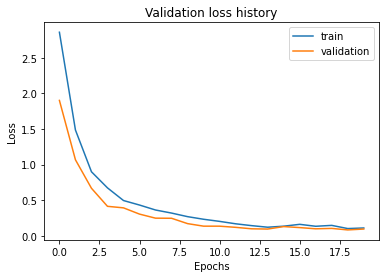

Training fold number:  2
accuracy: 93.64%


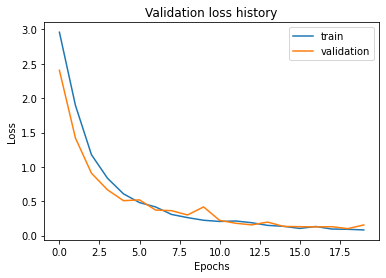

Training fold number:  3
accuracy: 97.88%


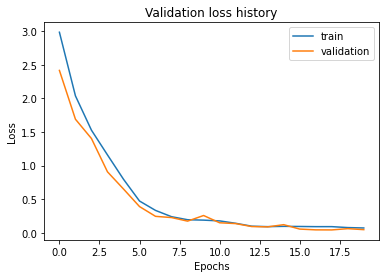

Training fold number:  4
accuracy: 97.88%


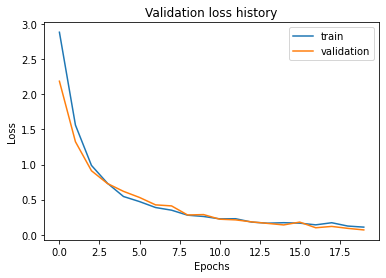

Training fold number:  5
accuracy: 97.88%


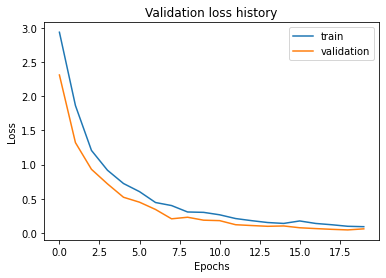

Training fold number:  6
accuracy: 98.23%


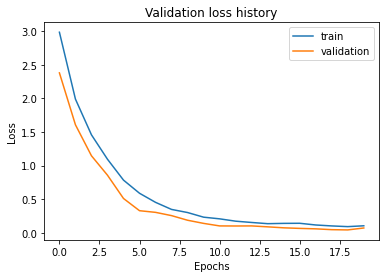

Training fold number:  7
accuracy: 97.88%


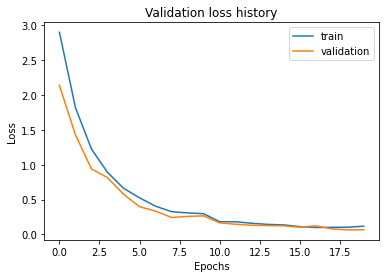

Training fold number:  8
accuracy: 96.47%


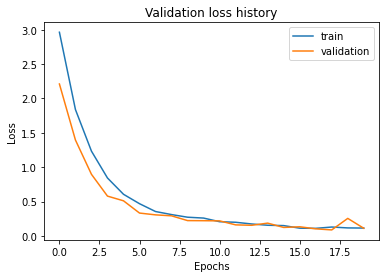

Training fold number:  9
accuracy: 97.87%


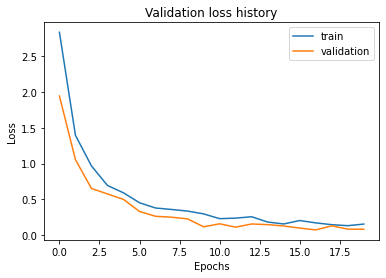

Training fold number:  10
accuracy: 97.87%


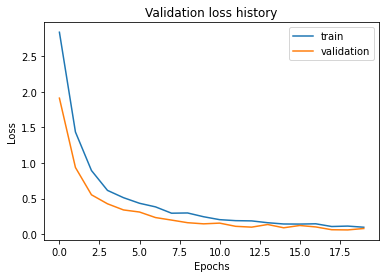

Average score: 97.31%
INFO:tensorflow:Assets written to: LSTM/assets


In [16]:
# save model
model = LSTM()
model.save("LSTM")


In [17]:
from tensorflow.keras import models
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics


def evaluate_model(model, X, y):
    # calculate precsion/recall/f1-score/accuracy of the model on the test set

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    predicted_targets = np.array([])
    actual_targets = np.array([])
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    for train, test in kfold.split(X, y):
        scores = model.evaluate(X[test], y[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

        y_pred = model.predict(X[test]).argmax(axis=-1)
        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, y[test])

        accuracy_list.append(metrics.accuracy_score(y[test], y_pred))
        precision_list.append(
            metrics.precision_score(y[test], y_pred, average="weighted")
        )
        recall_list.append(metrics.recall_score(
            y[test], y_pred, average="weighted"))
        f1_score_list.append(metrics.f1_score(
            y[test], y_pred, average="weighted"))

    print("Average accuracy= ", np.mean(accuracy_list))
    print("Average precision= ", np.mean(precision_list))
    print("Average recall= ", np.mean(recall_list))
    print("Average f1_score= ", np.mean(f1_score_list))

    return predicted_targets, actual_targets


In [18]:
class_names = le.inverse_transform(y)

In [19]:
model = models.load_model("LSTM")
predicted_target, actual_target = evaluate_model(model, X, y)


accuracy: 98.23%
9/9 [==============================] - 0s 14ms/step
accuracy: 97.17%
9/9 [==============================] - 0s 12ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 12ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 7ms/step
accuracy: 97.88%
9/9 [==============================] - 0s 6ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.58%
9/9 [==============================] - 0s 10ms/step
accuracy: 97.87%
9/9 [==============================] - 0s 7ms/step
Average accuracy=  0.9816129113099267
Average precision=  0.9837376492973815
Average recall=  0.9816129113099267
Average f1_score=  0.9816443759781401


# Ablation studies

Training fold number:  1
accuracy: 96.47%


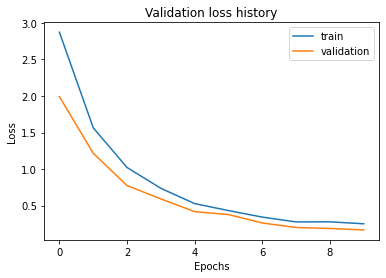

Training fold number:  2
accuracy: 95.41%


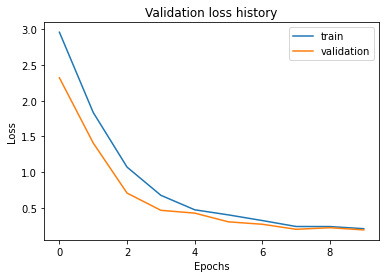

Training fold number:  3
accuracy: 94.70%


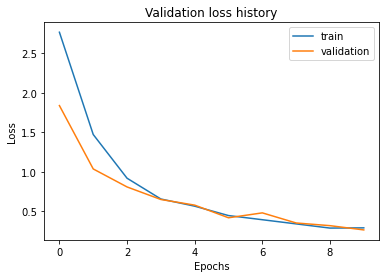

Training fold number:  4
accuracy: 92.23%


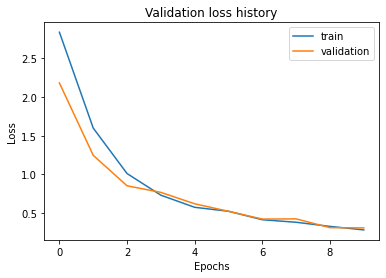

Training fold number:  5
accuracy: 97.53%


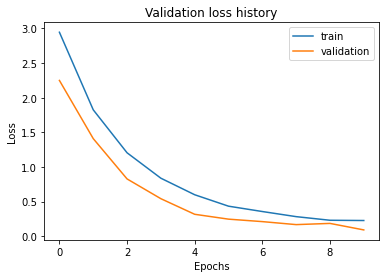

Training fold number:  6
accuracy: 96.47%


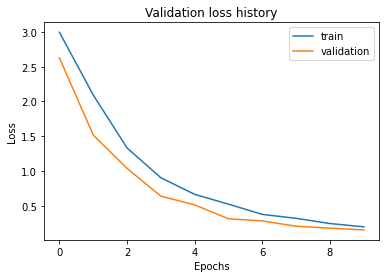

Training fold number:  7
accuracy: 94.70%


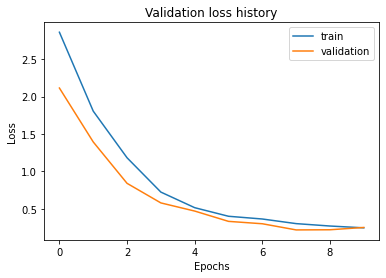

Training fold number:  8
accuracy: 95.41%


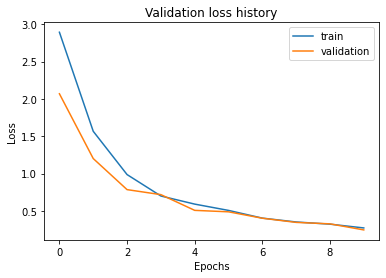

Training fold number:  9
accuracy: 95.39%


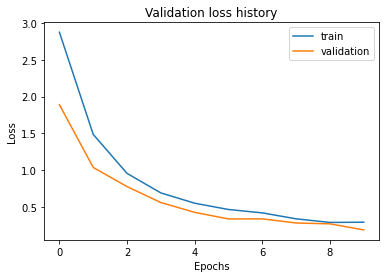

Training fold number:  10
accuracy: 95.39%


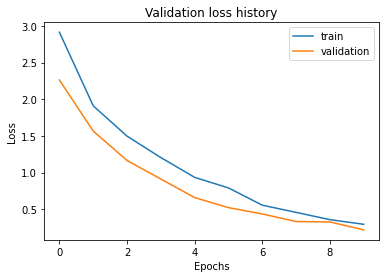

Average score: 95.37%
accuracy: 96.47%
9/9 [==============================] - 0s 6ms/step
accuracy: 95.41%
9/9 [==============================] - 0s 6ms/step
accuracy: 96.11%
9/9 [==============================] - 0s 6ms/step
accuracy: 95.76%
9/9 [==============================] - 0s 8ms/step
accuracy: 96.82%
9/9 [==============================] - 0s 7ms/step
accuracy: 97.53%
9/9 [==============================] - 0s 8ms/step
accuracy: 95.41%
9/9 [==============================] - 0s 7ms/step
accuracy: 94.70%
9/9 [==============================] - 0s 7ms/step
accuracy: 97.16%
9/9 [==============================] - 0s 17ms/step
accuracy: 95.39%
9/9 [==============================] - 0s 8ms/step
Average accuracy=  0.960751071348019
Average precision=  0.9649406175693672
Average recall=  0.960751071348019
Average f1_score=  0.9605472826941863


In [20]:
model = LSTM(num_epochs=10)
predicted_target, actual_target = evaluate_model(model, X, y)


Training fold number:  1
accuracy: 98.23%


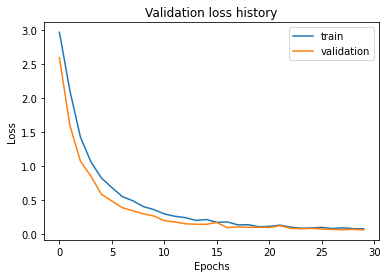

Training fold number:  2
accuracy: 96.82%


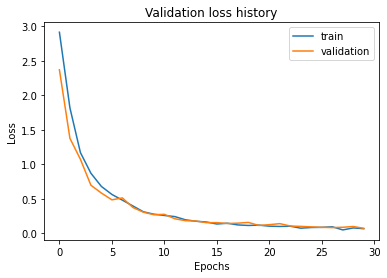

Training fold number:  3
accuracy: 97.17%


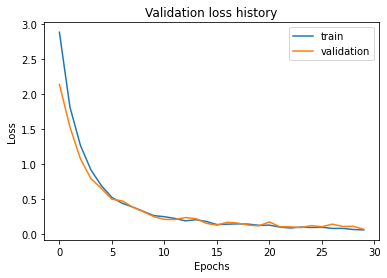

Training fold number:  4
accuracy: 96.47%


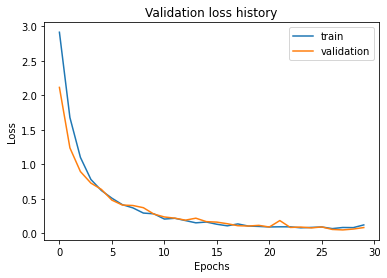

Training fold number:  5
accuracy: 98.59%


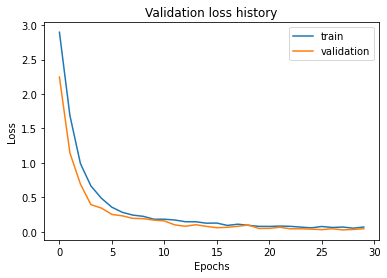

Training fold number:  6
accuracy: 97.53%


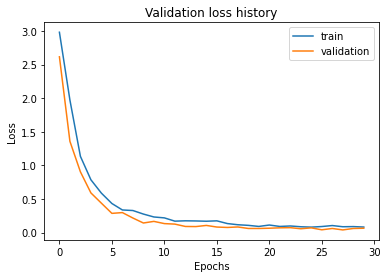

Training fold number:  7
accuracy: 97.17%


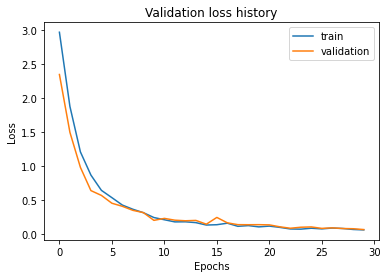

Training fold number:  8
accuracy: 97.88%


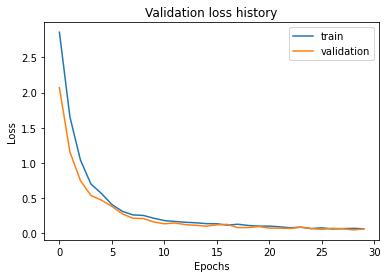

Training fold number:  9
accuracy: 98.58%


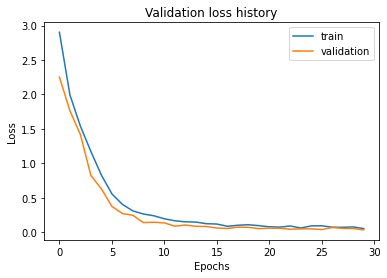

Training fold number:  10
accuracy: 97.87%


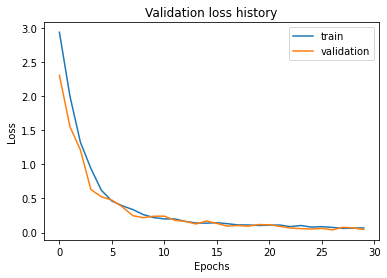

Average score: 97.63%
accuracy: 98.59%
9/9 [==============================] - 0s 7ms/step
accuracy: 96.82%
9/9 [==============================] - 0s 6ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 10ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 6ms/step
accuracy: 99.65%
9/9 [==============================] - 0s 6ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 8ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 8ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 8ms/step
accuracy: 97.87%
9/9 [==============================] - 0s 7ms/step
Average accuracy=  0.9869157707440543
Average precision=  0.988184171916598
Average recall=  0.9869157707440543
Average f1_score=  0.9869226313279074


In [21]:
model = LSTM(num_epochs=30)
predicted_target, actual_target = evaluate_model(model, X, y)


Training fold number:  1
accuracy: 98.23%


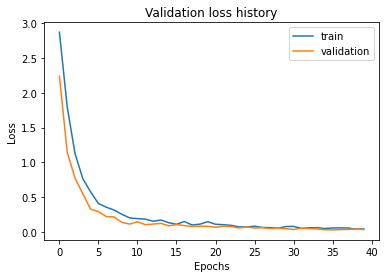

Training fold number:  2
accuracy: 96.82%


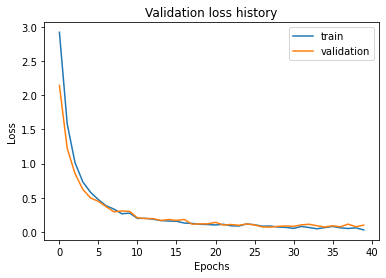

Training fold number:  3
accuracy: 98.59%


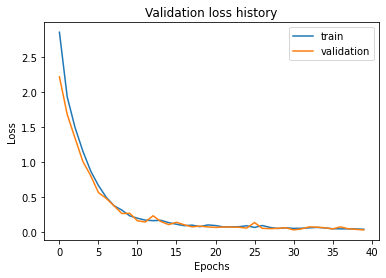

Training fold number:  4
accuracy: 98.59%


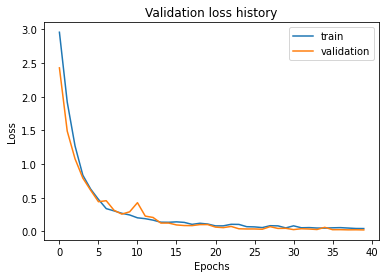

Training fold number:  5
accuracy: 98.94%


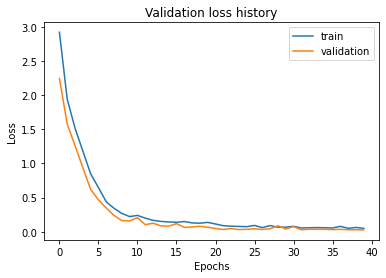

Training fold number:  6
accuracy: 98.59%


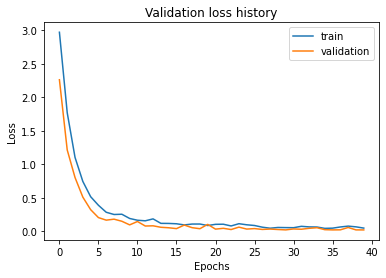

Training fold number:  7
accuracy: 97.88%


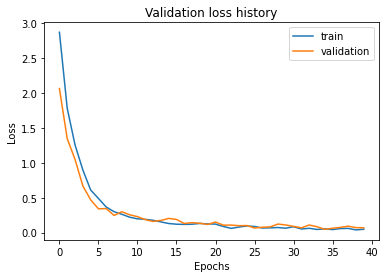

Training fold number:  8
accuracy: 97.88%


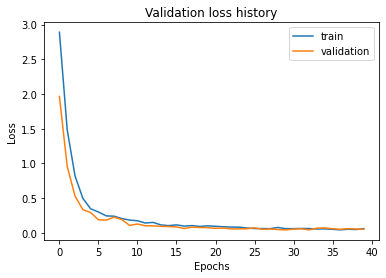

Training fold number:  9
accuracy: 99.29%


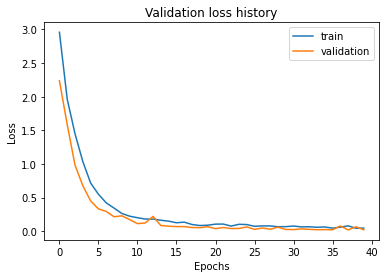

Training fold number:  10
accuracy: 98.23%


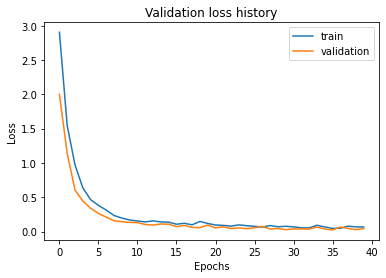

Average score: 98.30%
accuracy: 99.29%
9/9 [==============================] - 0s 7ms/step
accuracy: 95.76%
9/9 [==============================] - 0s 6ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 8ms/step
accuracy: 97.88%
9/9 [==============================] - 0s 8ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 7ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 8ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 6ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 8ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 17ms/step
Average accuracy=  0.984090168658998
Average precision=  0.9860590511640245
Average recall=  0.984090168658998
Average f1_score=  0.9840867014848298


In [22]:
model = LSTM(num_epochs=40)
predicted_target, actual_target = evaluate_model(model, X, y)


Training fold number:  1
accuracy: 97.88%


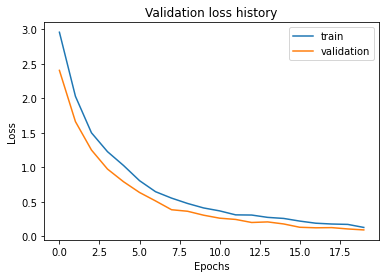

Training fold number:  2
accuracy: 96.82%


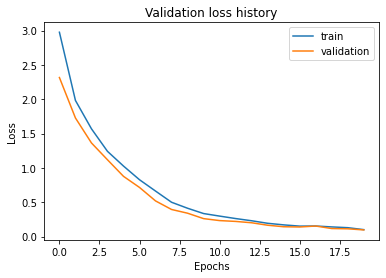

Training fold number:  3
accuracy: 96.11%


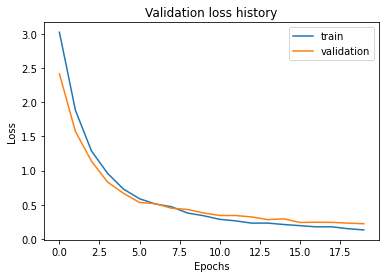

Training fold number:  4
accuracy: 96.82%


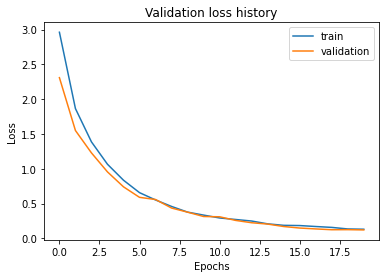

Training fold number:  5
accuracy: 98.94%


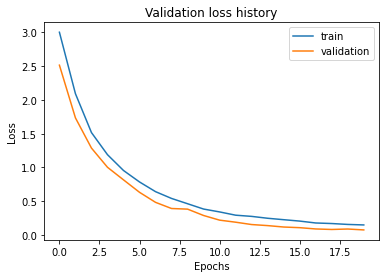

Training fold number:  6
accuracy: 98.59%


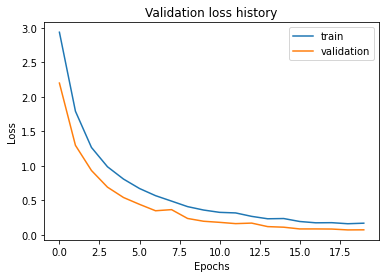

Training fold number:  7
accuracy: 96.82%


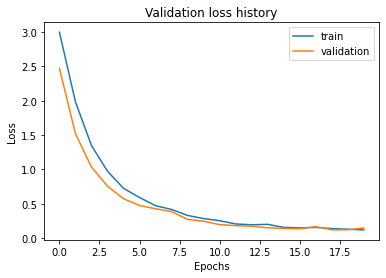

Training fold number:  8
accuracy: 97.17%


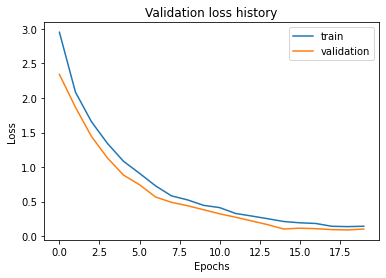

Training fold number:  9
accuracy: 97.52%


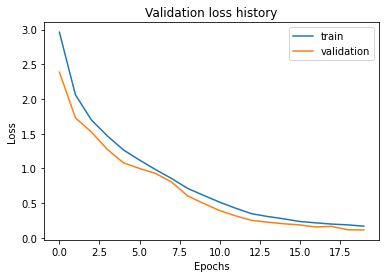

Training fold number:  10
accuracy: 97.52%


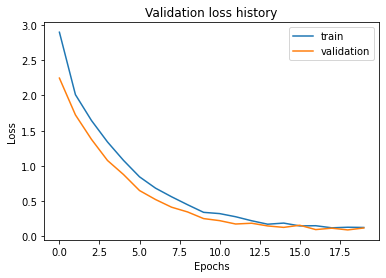

Average score: 97.42%
accuracy: 97.88%
9/9 [==============================] - 0s 5ms/step
accuracy: 97.17%
9/9 [==============================] - 0s 5ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 7ms/step
accuracy: 97.53%
9/9 [==============================] - 0s 6ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 6ms/step
accuracy: 99.29%
9/9 [==============================] - 0s 10ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 5ms/step
accuracy: 97.88%
9/9 [==============================] - 0s 6ms/step
accuracy: 98.58%
9/9 [==============================] - 0s 6ms/step
accuracy: 97.52%
9/9 [==============================] - 0s 7ms/step
Average accuracy=  0.9819650151617673
Average precision=  0.9838934132220352
Average recall=  0.9819650151617673
Average f1_score=  0.981866204645643


In [23]:
model = LSTM(num_units=32)
predicted_target, actual_target = evaluate_model(model, X, y)

Training fold number:  1
accuracy: 97.88%


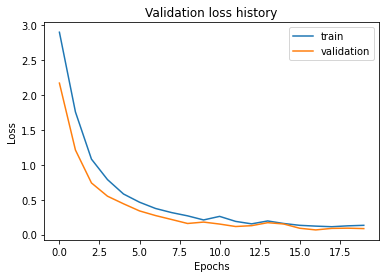

Training fold number:  2
accuracy: 96.47%


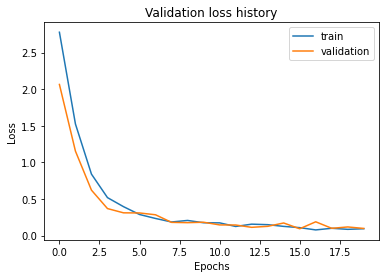

Training fold number:  3
accuracy: 97.17%


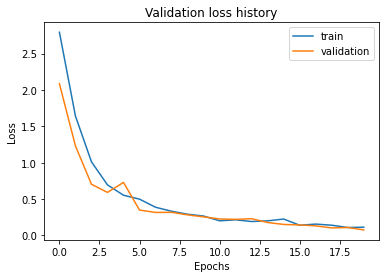

Training fold number:  4
accuracy: 95.76%


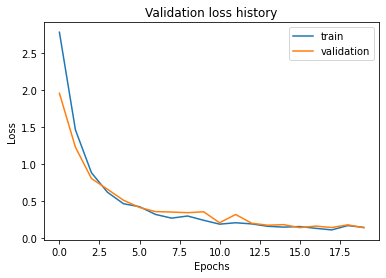

Training fold number:  5
accuracy: 98.23%


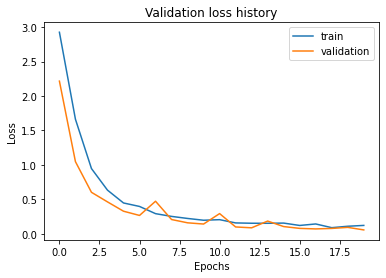

Training fold number:  6
accuracy: 97.17%


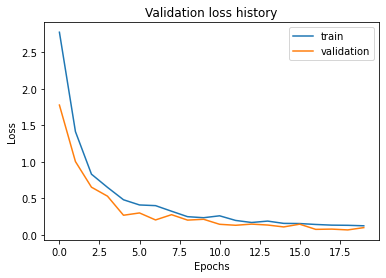

Training fold number:  7
accuracy: 97.88%


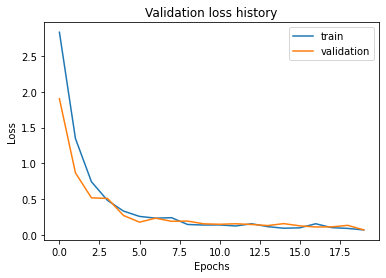

Training fold number:  8
accuracy: 96.11%


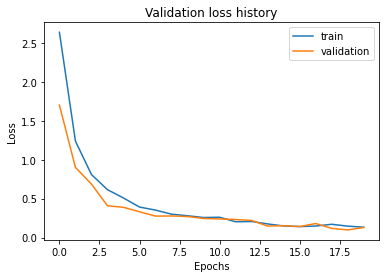

Training fold number:  9
accuracy: 97.16%


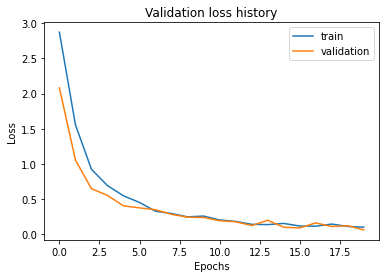

Training fold number:  10
accuracy: 96.81%


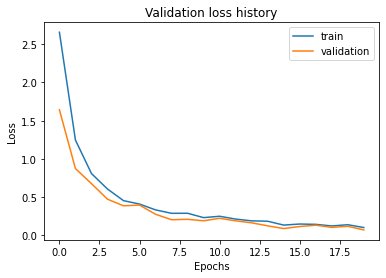

Average score: 97.07%
accuracy: 98.59%
9/9 [==============================] - 0s 11ms/step
accuracy: 96.11%
9/9 [==============================] - 0s 20ms/step
accuracy: 98.59%
9/9 [==============================] - 0s 12ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 12ms/step
accuracy: 98.23%
9/9 [==============================] - 0s 22ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 15ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 18ms/step
accuracy: 97.53%
9/9 [==============================] - 0s 12ms/step
accuracy: 98.94%
9/9 [==============================] - 0s 11ms/step
accuracy: 96.81%
9/9 [==============================] - 0s 12ms/step
Average accuracy=  0.9809036914517707
Average precision=  0.9828505439585433
Average recall=  0.9809036914517707
Average f1_score=  0.9808609374454631


In [24]:
model = LSTM(num_units=128)
predicted_target, actual_target = evaluate_model(model, X, y)